Imports

In [14]:
#import panda, numpy, matplotlib and display their versions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
print("pd:",pd.__version__)
print("numpy:",np.__version__)
print("plt:",matplotlib.__version__)
from scipy import stats
import math
from IPython.display import display, HTML
import statistics

pd: 0.25.3
numpy: 1.17.4
plt: 3.1.2


Some Tools, might be useful later

In [3]:
# number converter, convert '1.43k' to '1430', '1.36M' to '1360000'
def popsanalyze(s):
    if(s[len(s)-1]=='M'):
        return(int(float(s[0:len(s)-1])*math.pow(10,6)))
    elif(s[len(s)-1]=='k'):
        return(int(float(s[0:len(s)-1])*math.pow(10,3)))
    elif(s[len(s)-1]=='B'):
        return(int(float(s[0:len(s)-1])*math.pow(10,9)))
    else:
        return int(s)
       
# NaN values remover, kick the NaN values out of list
def nanremove(l):
    return([x for x in l if pd.isnull(x) == False and x != 'nan']) # stole from Internet, but pretty easy to write my own

read the population data, only keep countries with more than 10M people, and add them to dt

In [50]:
#read population data file and construct a new Dataframe for later iteration
popsdt = pd.read_csv("population_total.csv")
countrypops = pd.DataFrame(columns=['country','population'])

#iterrate through rows and calculate population mean of recent 20 years
for x in popsdt.iterrows():
    #population data start with year 1799 at col=1, so (column index+1798) = actual data of the year
    #output: list of country name at col=0, average population in recent 20 years(2002-2021)
    pops = [];
    for y in range(20):
        pops.append(popsanalyze(x[1][2002-1798+y]))
    average = int(statistics.mean(nanremove(pops)))
    # print(x[1][0],average)
    countrypops = countrypops.append({'country':x[1][0],'population':average}, ignore_index=True)
    
# Filter out country with population less than 10M
countrypops = countrypops[countrypops['population']>(10*10**6)]
countrypops = countrypops.set_index('country', drop=True)#set country names as index, drop the old index row
countrypops['population']=countrypops['population']/1000
countrypops = countrypops.rename(columns={"population":"population(k)"})
# print(countrypops)

             population(k)
country                   
Afghanistan          32035
Angola               25900
Argentina            42020
Australia            22950
Belgium              11090
...                    ...
Vietnam              90455
Yemen                24905
South Africa         53455
Zambia               14960
Zimbabwe             13375

[84 rows x 1 columns]


Read the other four datasets and combine them all together

In [176]:
# read the four datasets
vcc_safe = pd.read_csv("vccin_sfty_dag.csv") # percentage of parents who think vaccine is not safe
vcc_effective = pd.read_csv("vccin_effect_dag.csv") # percentage of parents who think vaccine is not effective
vcc_important = pd.read_csv("vccin_imptn_dag.csv") #  percentage of parents who think vaccine is not important
child_mortdt = pd.read_csv("child_mortality.csv") # number of children death before 5yo per 1000

#set index to country and only read data from year 2014 and 2017, because the data are only on those two years.
vcc_safe = vcc_safe.set_index('country')[['2014','2017']]
vcc_effective = vcc_effective.set_index('country')[['2014','2017']]
vcc_important = vcc_important.set_index('country')[['2014','2017']]

#calculate the mean
vcc_safe = vcc_safe.apply(lambda row: row.fillna(row.mean()), axis='columns')# this means: for each row under 'columns', apply this 'row:' function
vcc_safe['safe_avg']=(vcc_safe['2014'] + vcc_safe['2017'])/2 # calculate the average
vcc_effective = vcc_effective.apply(lambda row: row.fillna(row.mean()), axis='columns') # same for the other 2
vcc_effective['eff_avg']=(vcc_effective['2014'] + vcc_effective['2017'])/2
vcc_important = vcc_important.apply(lambda row: row.fillna(row.mean()), axis='columns')
vcc_important['imp_avg']=(vcc_important['2014'] + vcc_important['2017'])/2

#merge three lists, remove individual data columns
vcc = pd.concat([vcc_safe,vcc_effective,vcc_important],
                axis = 'columns', 
                join = 'inner', 
                sort = 'false')
vcc = vcc.drop(['2014','2017'],
                axis = 'columns')

#combine countrypops and vcc
dt = pd.DataFrame()
dt = pd.concat([countrypops,vcc], 
               join = 'inner', 
               axis = 'columns')

#add data from child mortality
child_mort = pd.DataFrame(columns=['country','child_mort'])
for x in child_mortdt.iterrows():
    #child_mort data start with year 1799 at col=1, so (column index+1798) = actual data of the year
    #output: list of country name at col=0, average population in recent 20 years(2002-2021)
    child_mort_20y = [];
    for y in range(20):
        child_mort_20y.append(x[1][2002-1798+y])
    average = statistics.mean(nanremove(child_mort_20y))
    #add country name and average mortality rate into one dataframe
    child_mort = child_mort.append({'country':x[1][0],'child_mort':average}, ignore_index=True)
    
child_mort = child_mort.set_index('country', drop=True)#set country names as index, drop the old index row

dt = pd.concat([dt,child_mort], 
               join = 'inner', 
               axis = 'columns')

sensitive_cty_list = ['Taiwan','Iran', 'Pakistan', 'Ukraine', 'Russia', 'Saudi Arabia']
dt = dt.drop(labels=sensitive_cty_list,axis=0)

dt = dt.sort_values(["population(k)"])
# dt.loc["Egypt"]

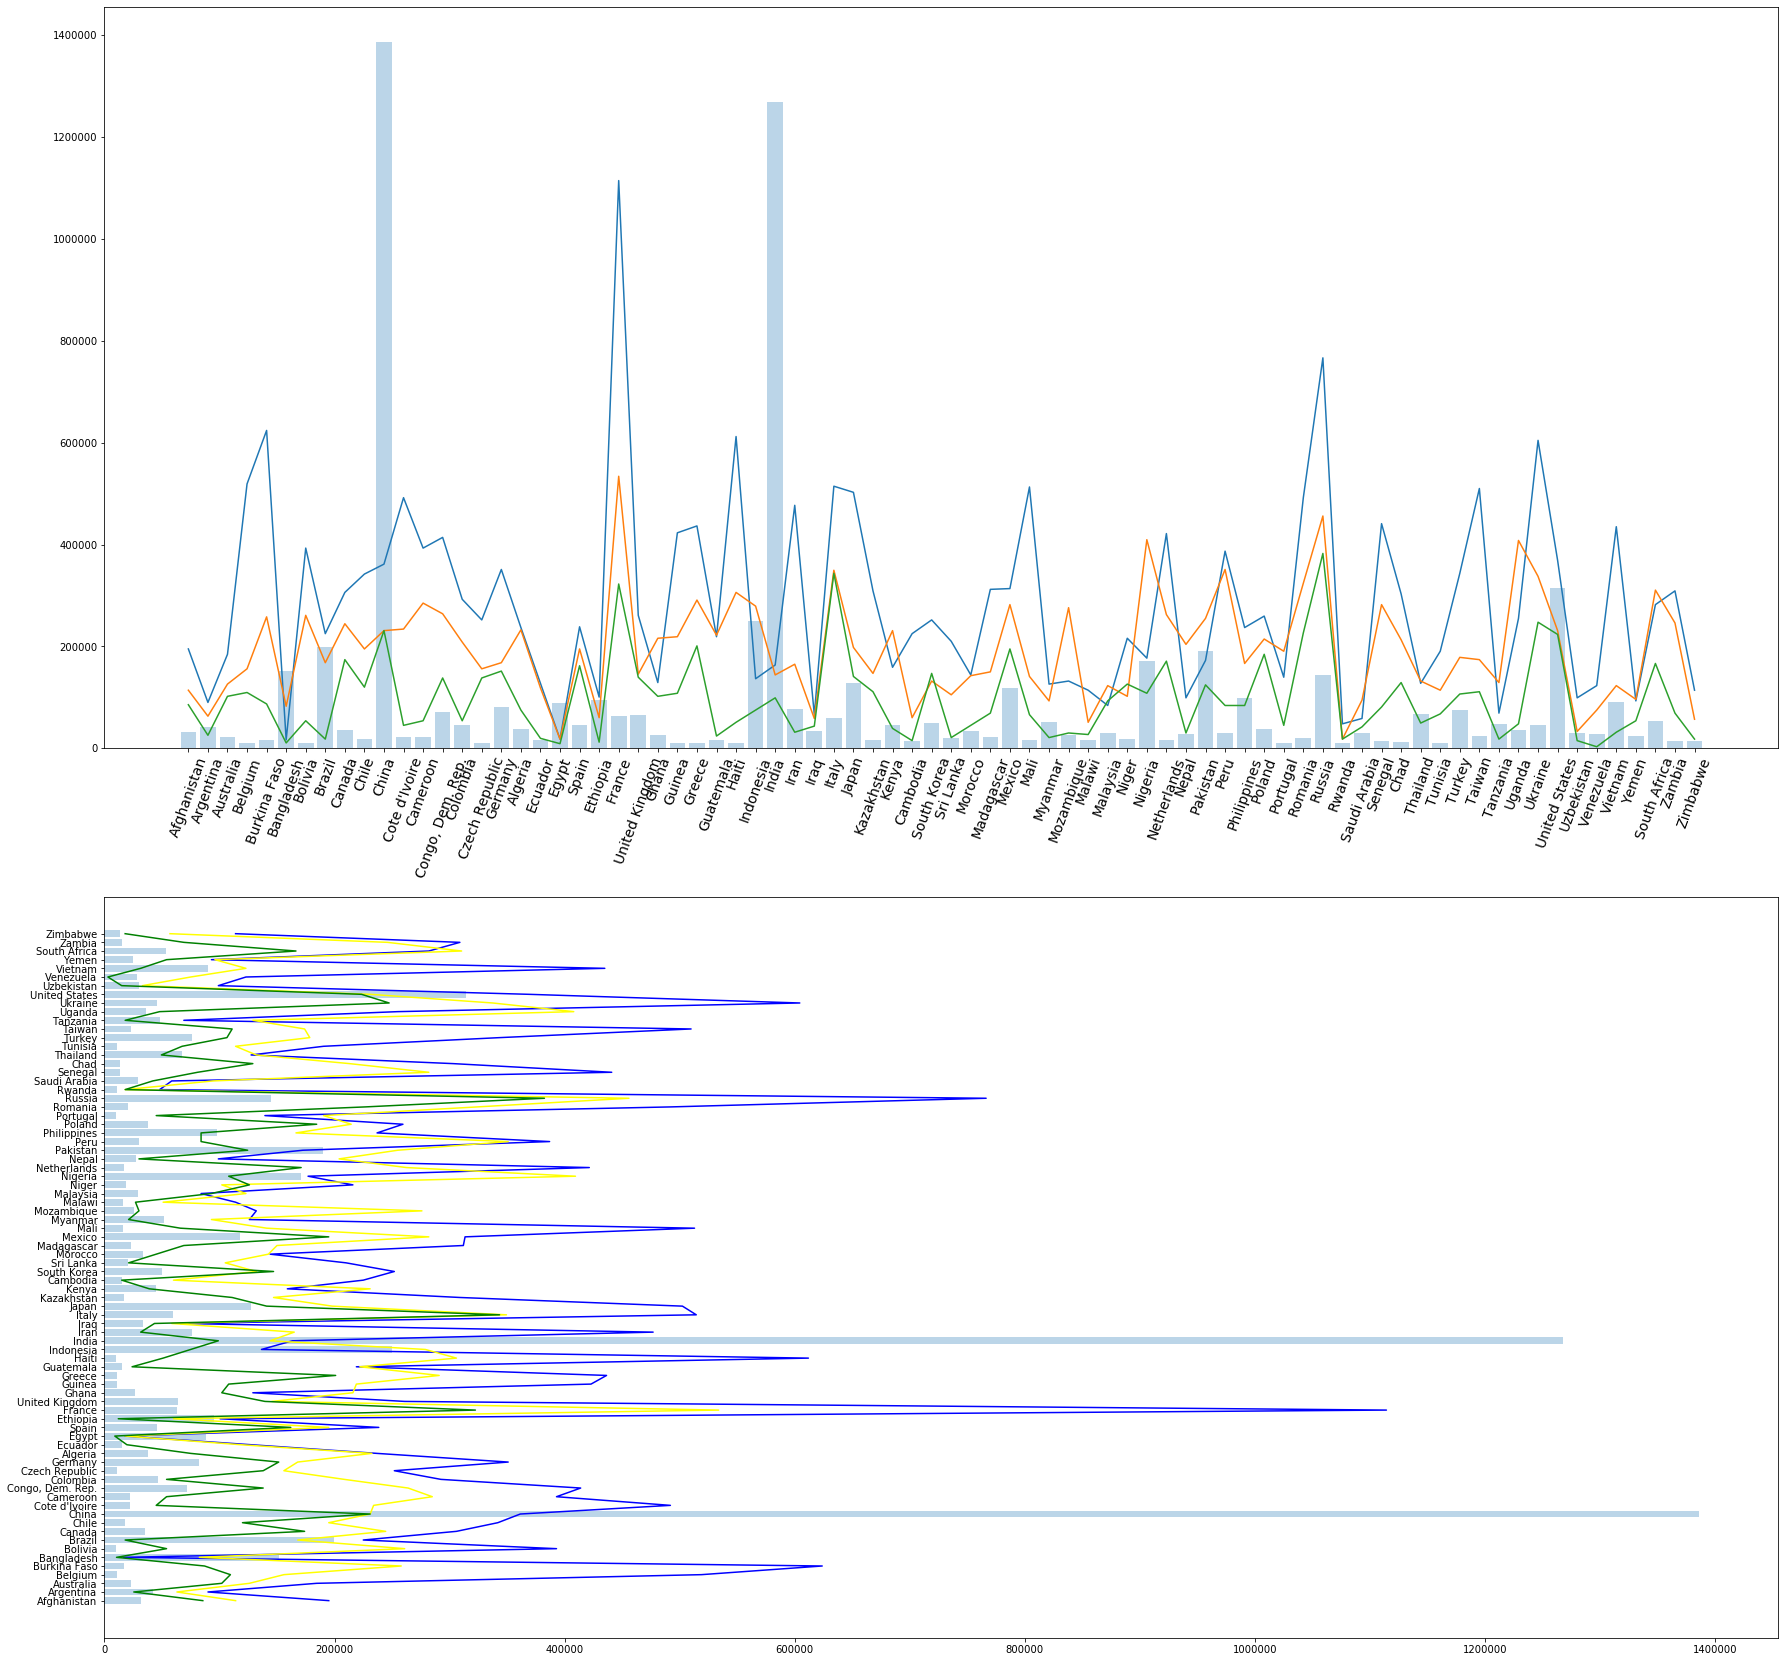

In [137]:
# fig, ax = plt.subplots(2,1,figsize=(30,30))

# ax[0].bar(dt.index,dt["population(k)"],alpha=.3)
# ax[0].plot(dt.index,dt['safe_avg']*30000)
# ax[0].plot(dt.index,dt['eff_avg']*30000)
# ax[0].plot(dt.index,dt['imp_avg']*30000)
# ax[0].tick_params(axis='x', labelrotation=70, labelsize=14)

# ax[1].barh(dt.index,dt["population(k)"],alpha=.3)
# ax[1].plot(dt['safe_avg']*30000,dt.index,color='blue',label="not safe")
# ax[1].plot(dt['eff_avg']*30000,dt.index,color='yellow',label="not effective")
# ax[1].plot(dt['imp_avg']*30000,dt.index,color='green',label="not important")

# plt.show()

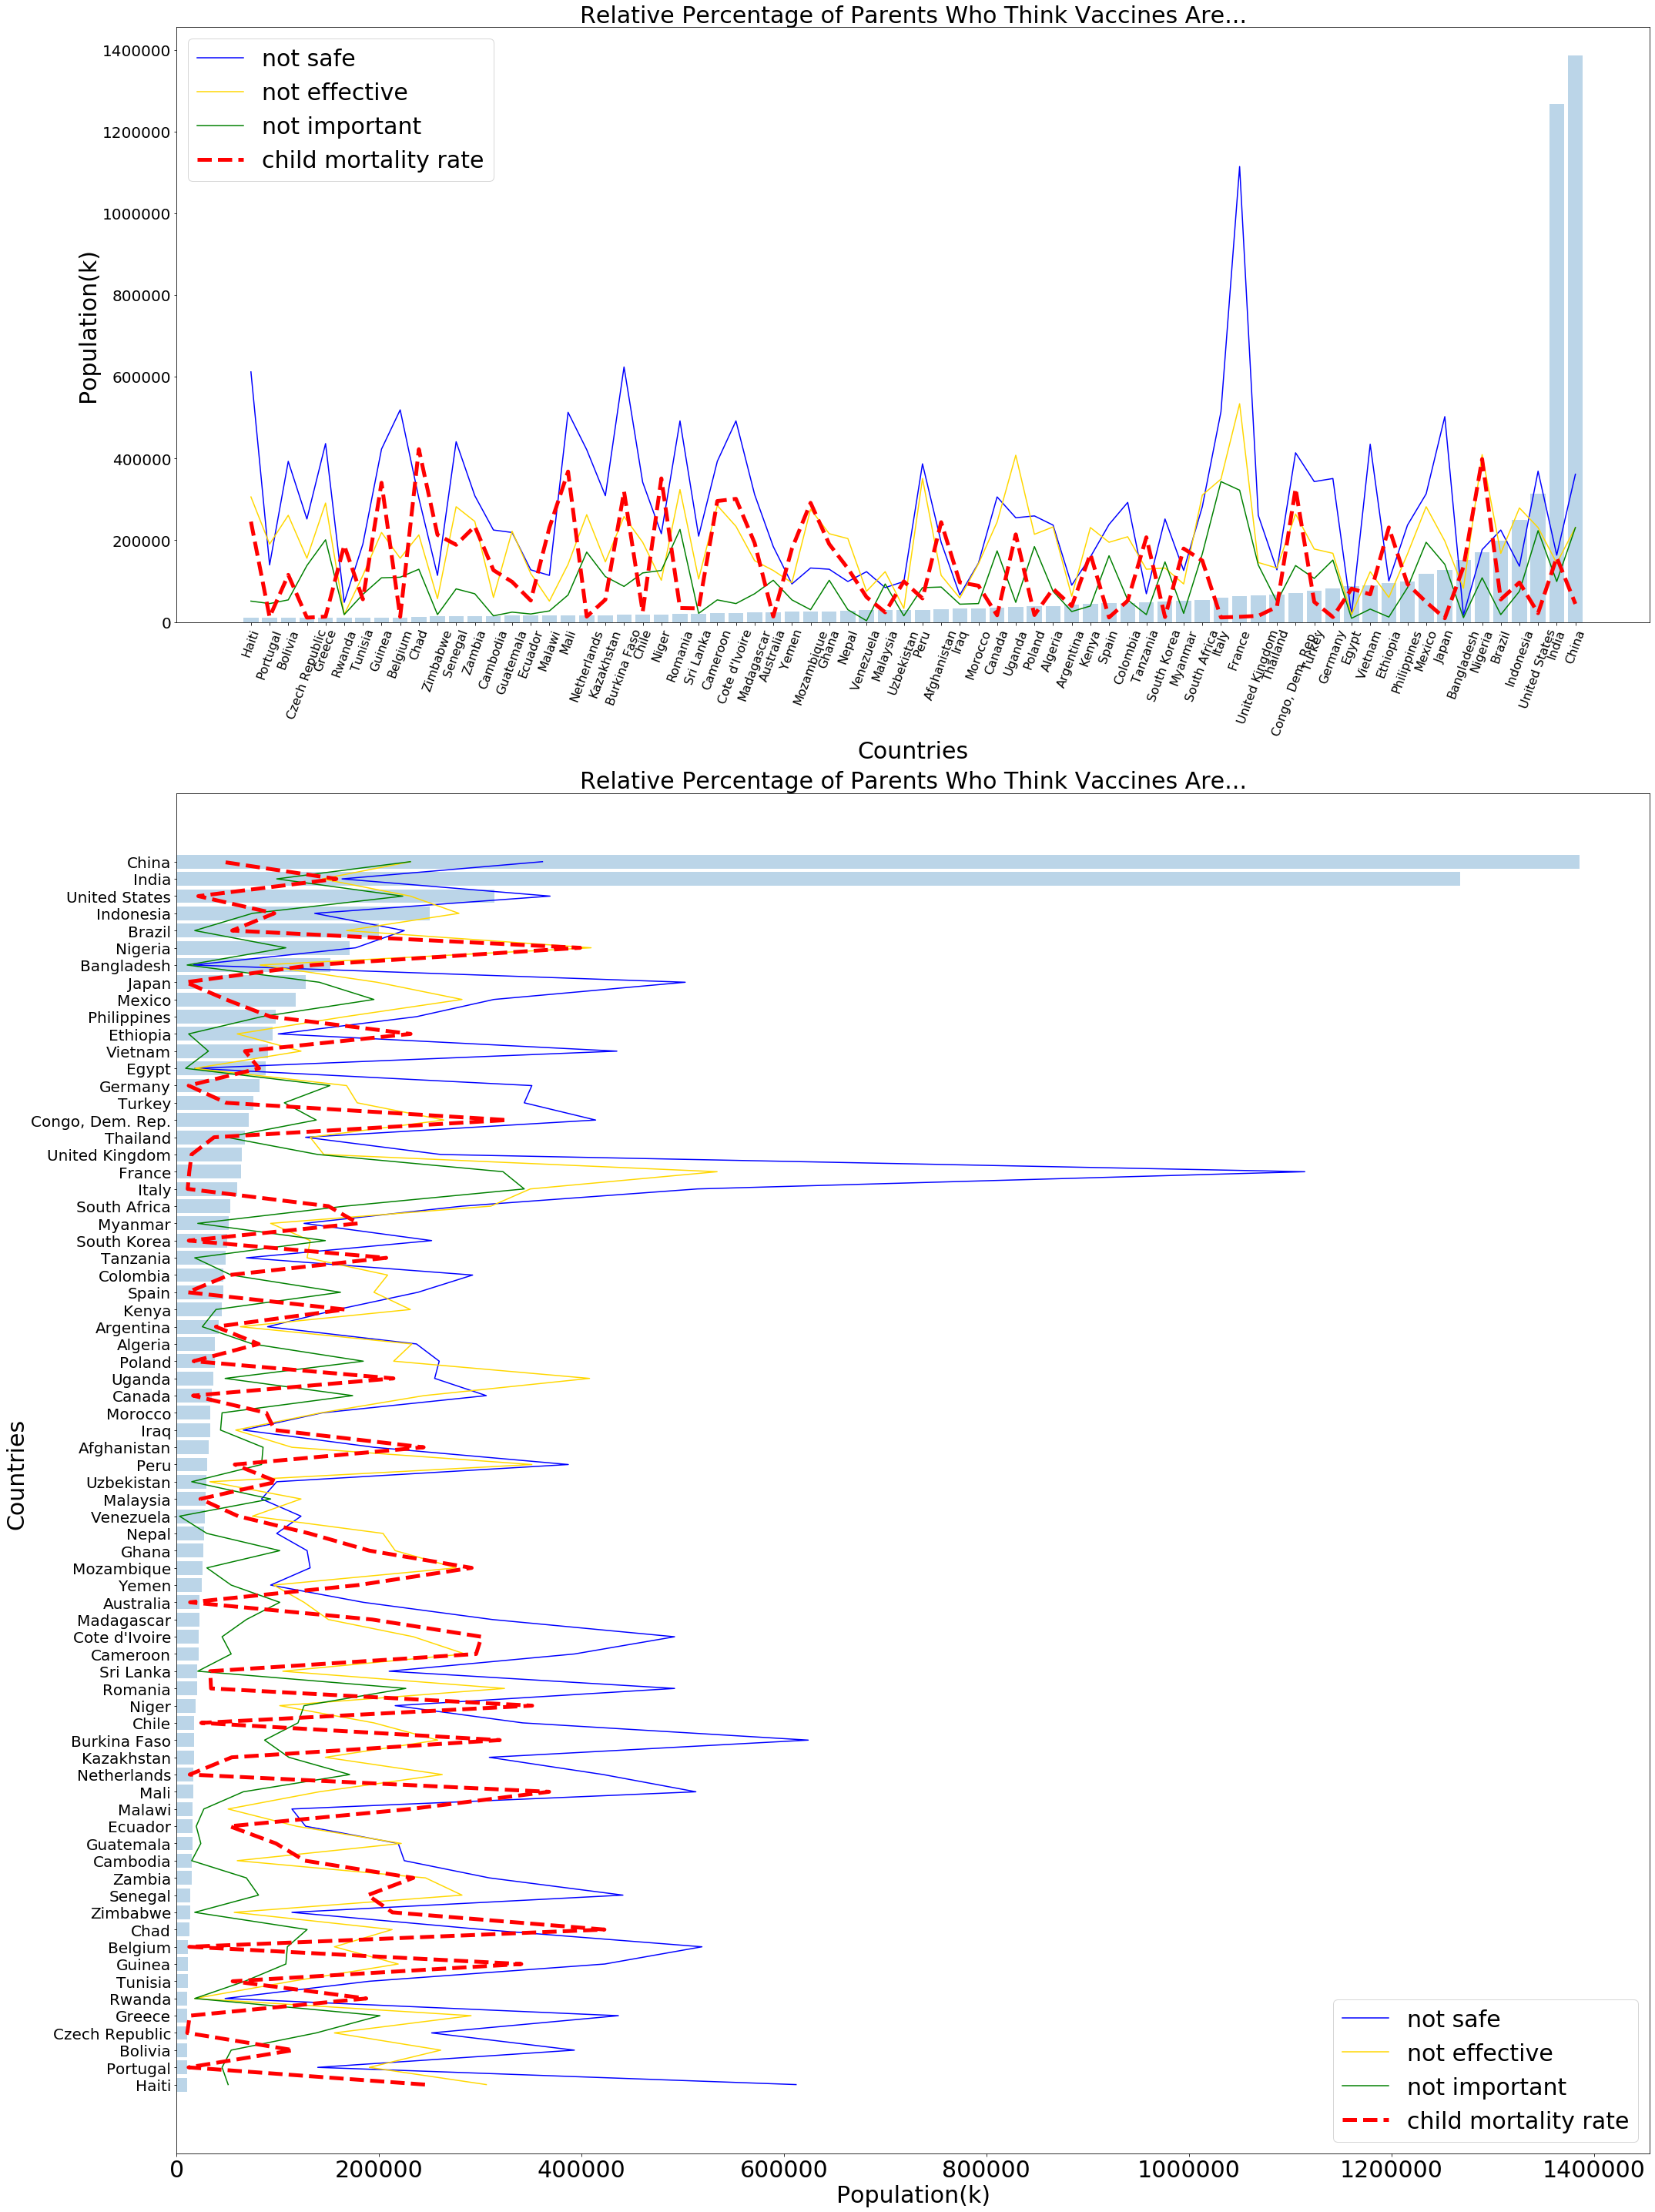

In [196]:
fig = plt.figure()
fig.set_size_inches(30,40)

ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)

ax1.bar(dt.index,dt["population(k)"],alpha=.3)
ax1.plot(dt.index,dt['safe_avg']*30000,color='blue',label="not safe")
ax1.plot(dt.index,dt['eff_avg']*30000,color='gold',label="not effective")
ax1.plot(dt.index,dt['imp_avg']*30000,color='green',label="not important")
ax1.plot(dt.index,dt['child_mort']*3000,"--",color='red',linewidth=5,label="child mortality rate")
ax1.tick_params(axis='x', labelrotation=70, labelsize=16)
ax1.tick_params(axis='y', labelsize=20)

ax1.set_title("Relative Percentage of Parents Who Think Vaccines Are...",size=30)
ax1.set_xlabel("Countries",size=30)
ax1.set_ylabel("Population(k)",size=30)

ax2.barh(dt.index,dt["population(k)"],alpha=.3)
ax2.plot(dt['safe_avg']*30000,dt.index,color='blue',label="not safe")
ax2.plot(dt['eff_avg']*30000,dt.index,color='gold',label="not effective")
ax2.plot(dt['imp_avg']*30000,dt.index,color='green',label="not important")
ax2.plot(dt['child_mort']*3000,dt.index,"--",color='red',linewidth=5,label="child mortality rate")
ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=20)

ax2.set_title("Relative Percentage of Parents Who Think Vaccines Are...",size=30)
ax2.set_ylabel("Countries",size=30)
ax2.set_xlabel("Population(k)",size=30)


ax1.legend(prop={'size': 30})
ax2.legend(prop={'size': 30})
plt.tight_layout()
plt.savefig("graph.png",dpi=fig.dpi)

plt.show()
